# AI4Trust · Daily News Collection Analysis Notebook

This notebook provides an overview and analysis of news data collected daily on the **AI4Trust** platform. The goal is to visualize how many news items are collected each day within a given date range, and to break down these counts by language, country, and topic for deeper insights. Below is a summary of the notebook's purpose, inputs, outputs, and workflow:

---

## 1  Purpose

* **Primary goal:** Quantify the volume of news collected per day between two dates and visualise the results.  
* **Secondary goals:** Expose linguistic, geographic, and topical patterns by adding optional breakdowns.

---

## 2  Data Source

* Raw articles are fetched from a **Trino / Iceberg** data lake managed by AI4Trust.  
* **Date handling**  
  * Each record is timestamped by `publish_date`; if that field is missing, `created_at` is used.  
  * Timestamps are converted to **Unix seconds** to ensure sorting and filtering are **timezone‑agnostic** and stable across runs.  
  * Rows dated **before 2025** are excluded.  
* **Deduplication**  
  * After date filtering, rows are deduplicated on `url`, **keeping only the first occurrence**.  
  * This guarantees a one‑row‑per‑article basis for every aggregation.

---

## 3  Determinism & Reproducibility

* Sorting on Unix epoch time ⟶ **consistent row order**.  
* Filtering and deduplication **inside the window** ⟶ identical results unless the upstream table truly changes.  
* All intermediate results are saved to disk as JSON, so downstream plots rerun from a fixed snapshot.

---

## 4  Notebook Inputs & Outputs

| Stage | User input | Code action | File output | Visual output |
|-------|------------|-------------|-------------|---------------|
| **Aggregation** | *Start date*, *End date* | Group by day, language, country, topic | `news_article_counts_by_<scope>.json` (4 files) | — |
| **Daily counts** | none (uses JSON) | Load daily JSON | — | Bar plot of **total** daily news count |
| **By language** | optional `selected_language` | Load language JSON; plot either all languages (stacked) or the chosen one | — | Bar plot per language |
| **By country** | optional `selected_country` | Same pattern as language | — | Bar plot per country |
| **By topic** | optional `selected_topic` | Same pattern as language | — | Bar plot per topic |

> The JSON files decouple heavy aggregation from lightweight plotting, enabling quick re‑plots without re‑querying the lake.

---

## 5  Visualisation Options

Each category‑based visualisation cell contains **commented examples**:

```python
# available_languages = [...]
# selected_language = "en"  # choose from the list above





## Input Parameters

* **Date Range:** The user specifies a start date and end date to define the period of analysis. The notebook will focus on all news items collected between these dates.
* **Filters (Optional):** For certain visualizations, the user can select a specific **language**, **country**, or **topic** to filter the data. If no filter is applied, the visualization will include all languages/countries/topics in the dataset.

## Workflow Overview

1. **Data Aggregation (JSON Creation):**

   * **Input:** The raw news records from the AI4Trust dataset within the selected date range (defined by the start and end dates).
   * **Output:** A structured **JSON file** containing the aggregated number of news items per day, as well as breakdowns by language, country, and topic for each day.
   * **Details:** In this step, the notebook groups the news data by date (and by category) to compute daily counts. We generate a JSON file to store these results, which makes it easy to reuse the aggregated data for multiple visualizations. Using a JSON intermediary also ensures the data is pre-processed and ready for plotting, and it can be saved or shared for future analysis. (This step is essentially preparing the data: it **explains any transformation** – grouping by date, filtering by range – and sets up the logic for the analysis.)

2. **Loading Data for Visualization:**

   * **Input:** The JSON file created in the previous step.
   * **Output:** An in-memory data structure (e.g., a pandas DataFrame) loaded with the daily counts and metadata, ready to be used for plotting.
   * **Details:** The notebook reads the JSON file and loads the data into a convenient format for analysis. This step confirms that the data has been correctly aggregated and is accessible for visualization. (It’s a straightforward step with the logic of reading data from the JSON; we include it to clearly **explain any data loading or edits** and to ensure the data integrity before plotting.)

3. **Overall Daily News Count Visualization:**

   * **Input:** The aggregated daily counts (across all languages, countries, and topics) from the loaded data.
   * **Output:** A **bar plot** showing the total number of news items collected each day in the specified date range. Each bar on the chart represents a single day, and its height represents the total news count for that day.
   * **Details:** This visualization provides a high-level view of the data collection over time. By looking at this chart, we can quickly identify general trends – for example, which days had a surge in collected news and which days had relatively few. (The notebook will explain the plotting logic here, such as how we iterate through each date and plot the count, so the reader understands **how the code generates the chart** and **why this overall view is useful** as a baseline.)

4. **Daily News Count by Language:**

   * **Input:** The daily news counts broken down by language (derived from the aggregated data). The user can choose to view **all languages together** or focus on a **single language**.
   * **Output:** A bar chart visualizing the number of news items per day for each language category. If viewing all languages, the chart will display multiple series (e.g. color-coded bars or a stacked bar for each day) to represent each language’s contribution per day. If a single language is selected, the chart will show that language’s daily counts over time.
   * **Details:** This section helps to uncover linguistic patterns in the news data. The code groups the data by both date and language to compute daily counts per language. By comparing these, one can see how different language news sources contribute over time. For example, one might observe that some days have a high volume of English-language news while others have more Italian or French news. We clearly explain the filtering mechanism (how selecting a language works in the code) and the plotting logic (e.g. grouping by language) so that readers understand **how the chart is constructed**. We also note **why** this view is important – it allows analysts to identify trends or anomalies in specific languages, which is useful for multilingual news monitoring.

5. **Daily News Count by Country:**

   * **Input:** The daily news counts categorized by the country of origin of each news item. The user can view **all countries** together or filter to a **single country** of interest.
   * **Output:** A bar plot showing the number of news items per day for each country. With all countries selected, the chart may use grouped or stacked bars to show each country’s daily counts side by side. With one country selected, the chart simply shows that country’s trend over the specified period.
   * **Details:** This visualization highlights geographic patterns in the news collection. The notebook’s code aggregates counts by date and country, and we explain this grouping in the text. By examining this chart, readers can see, for instance, if certain dates correspond to spikes in news from a particular country (perhaps due to local events or breaking news in that region). We ensure to explain **the logic** of how the country filter is applied and how the plot is generated. We also explain **why** this view is useful – it provides insight into which regions are contributing more news on which days, helping to identify country-specific surges or gaps in the data.

6. **Daily News Count by Topic:**

   * **Input:** The daily news counts organized by topic/category of the news items. The user can include **all topics** in one view or focus on **one specific topic** (for example, a topic like climate change, public health, migration, etc., depending on the categories defined in the dataset).
   * **Output:** A bar chart showing the number of news items per day for each topic category. If all topics are visualized together, the chart will illustrate each topic’s daily count (often via differently colored bar segments or multiple bars per day). If one topic is selected, the chart will display the daily trend for that single topic.
   * **Details:** This part of the analysis lets us see which subjects are most prominent in the collected news over time. The code computes daily counts per topic by grouping the data accordingly, and we describe this process for clarity. Readers can observe patterns such as specific days where a certain topic spikes (e.g., a surge in climate-related news on a day of a climate summit). The notebook text will clarify **how** the topic filtering and plotting works in the code and **why** it’s done – mainly to understand the thematic focus of news on different days and to detect any notable shifts in attention across topics.




In [ ]:
# News Items Over Time (March–June 2025) – Debugging Script

In [ ]:
# 1. Setup and Imports

In [ ]:
# Optional: Install necessary packages (if not already installed)
# !pip install "trino[sqlalchemy]==0.332.0" polars matplotlib pandas

import os
import re
import json
import datetime as dt
from pathlib import Path
from typing import Optional, Tuple

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sqlalchemy.engine import create_engine


In [ ]:
# 2. Helper Functions for Parsing and I/O

In [ ]:
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    """Parse host and port (with default and valid range checks)."""
    host = (host or "").strip()
    port = (port or "").strip()
    # Strip any scheme like http:// or tcp://
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65535):
        port_int = default_port
    return host or "localhost", port_int

def save_dict(d: dict, path: Path):
    """Save a dictionary as JSON to the given path (with date handling)."""
    def _json_default(value):
        if isinstance(value, (dt.datetime, dt.date)):
            return value.isoformat()
        return repr(value)
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load JSON data from a file into a Python dictionary."""
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate a Polars DataFrame from stored data, parsing 'date' to datetime."""
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})

def _maybe_format_date_axis(ax, x_values):
    """
    If x_values look like datetime, format the x-axis with date labels to avoid clutter.
    Uses an AutoDateLocator for smart date tick spacing.
    """
    # Convert to numpy array for type checking
    if hasattr(x_values, "to_numpy"):
        x_array = x_values.to_numpy()
    else:
        x_array = np.array(x_values)
    if x_array.size == 0:
        return ax  # nothing to format
    first_elem = x_array[0]
    # Check if data is datetime-like
    if pd.api.types.is_datetime64_any_dtype(x_array) or isinstance(first_elem, (pd.Timestamp, np.datetime64)):
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.figure.autofmt_xdate()  # rotate labels for readability
    return ax


In [ ]:
# 3. Connect to Trino and Configure Schema

In [ ]:
# Read connection settings from environment (with defaults)
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER",    "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
TRINO_SCHEMA  = os.getenv("TRINO_SCHEMA")  # optional preferred schema

# print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}'"
#       f" (requested schema={TRINO_SCHEMA or 'auto-detect'})")

# Create SQLAlchemy engine for Trino
engine = create_engine(f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}")

TARGET_TABLE = "collected_news"

def find_schema_with_table(engine, catalog: str, table: str, preferred: Optional[str] = None) -> str:
    """Find which schema in the catalog contains the specified table (or use preferred)."""
    with engine.connect() as conn:
        schemas = pd.read_sql(f"SHOW SCHEMAS FROM {catalog}", conn)["Schema"].tolist()
        if preferred:
            if preferred not in schemas:
                raise ValueError(f"Schema '{preferred}' not found in catalog '{catalog}'. Available: {schemas}")
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{preferred}", conn)["Table"].tolist()
            if table not in tables:
                raise ValueError(f"Table '{table}' not found in schema '{preferred}'.")
            return preferred
        # If no preferred schema provided, search all schemas for the table
        for sch in schemas:
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{sch}", conn)["Table"].tolist()
            if table in tables:
                return sch
    raise ValueError(f"Table '{table}' not found in any schema of catalog '{catalog}'.")

# Determine active schema containing the target table
ACTIVE_SCHEMA = find_schema_with_table(engine, TRINO_CATALOG, TARGET_TABLE, TRINO_SCHEMA)
# print(f"✅ Using schema '{ACTIVE_SCHEMA}'")


In [ ]:
# 4. Retrieve News Article Data from Trino

In [ ]:
# Define which columns to retrieve (include 'created_at' for date fallback)
COLUMNS_NEEDED = ["url", "publish_date", "created_at", "language", "topic", "keyword", "domain", "sourcecountry"]
TABLE_FQN = f"{TRINO_CATALOG}.{ACTIVE_SCHEMA}.{TARGET_TABLE}"
DATE_FILTER = ""  # e.g., "WHERE publish_date >= DATE '2025-01-01'" if needed to restrict at query time

SQL_QUERY = f"""
SELECT {', '.join(COLUMNS_NEEDED)}
FROM   {TABLE_FQN}
{DATE_FILTER}
"""

# Execute the query and load into a pandas DataFrame
with engine.connect() as conn:
    df_raw = pd.read_sql(SQL_QUERY, conn)

# print(f"✅ Retrieved {len(df_raw):,} rows from {TABLE_FQN}")


In [ ]:
# 5. Clean and Prepare Date Fields

In [ ]:
# Convert date columns to timezone-naive datetimes for consistency
for col in ("publish_date", "created_at"):
    df_raw[col] = pd.to_datetime(df_raw[col], errors="coerce", utc=True).dt.tz_localize(None)

# Use "publish_date" as primary date; if missing or NaN, fall back to "created_at"
df_raw["publish_date"] = df_raw["publish_date"].fillna(df_raw["created_at"])

# Remove any rows with dates before 2025 (ignore older data)
before_count = len(df_raw)
df_raw = df_raw[df_raw["publish_date"].dt.year >= 2025].copy()
removed_count = before_count - len(df_raw)
# print(f"📉 Removed {removed_count:,} articles dated before 2025; {len(df_raw):,} remain.")

# Convert all dates to Unix timestamp (seconds since epoch) for stable sorting/filtering
df_raw["date_ts"] = df_raw["publish_date"].astype(np.int64) // 10**9

# Sort the data chronologically by the timestamp
df_raw.sort_values("date_ts", inplace=True)
df_raw.reset_index(drop=True, inplace=True)


In [ ]:
# 6. Filter Articles to Date Window (2025-03-01 to 2025-07-27) and Remove Duplicates

In [ ]:
WINDOW_START = pd.to_datetime("2025-03-01")
WINDOW_END   = pd.to_datetime("2025-07-27")

# Convert window bounds to Unix timestamps before filtering
WINDOW_START_TS = int(WINDOW_START.timestamp())
WINDOW_END_TS   = int(WINDOW_END.timestamp())

# Filter the dataset to the specified time window (inclusive of start and end dates)
mask = df_raw["date_ts"].between(WINDOW_START_TS, WINDOW_END_TS)
df_window = df_raw.loc[mask].copy()
df_window["date"] = df_window["publish_date"].dt.floor("D")  # floor to day precision

# Deduplicate articles in the window based on URL (keep only the first occurrence)
pre_window_count = len(df_window)
df_window = df_window.drop_duplicates(subset="url", keep="first").reset_index(drop=True)
duplicates_dropped = pre_window_count - len(df_window)

# print(f"🗓 Filtered to date window: {WINDOW_START.date()} to {WINDOW_END.date()}")
# print(f"   Articles in window (deduplicated): {len(df_window):,} "
#       f"(out of {df_raw['url'].nunique():,} unique 2025 articles; {duplicates_dropped:,} duplicates dropped in window)")
# if len(df_window) > 0:
#     print(f"   Date range in filtered data: {df_window['date'].min().date()} -> {df_window['date'].max().date()}")


In [ ]:
# 7. Compute and Save Article Count JSON Files

In [ ]:
# Daily article counts by date
daily_counts_pd = (
    df_window.groupby("date")
             .size()
             .reset_index(name="news_count")
             .sort_values("date")
)
# print(f"✅ Daily counts calculated for {daily_counts_pd.shape[0]} days; columns = {list(daily_counts_pd.columns)}")
# print(daily_counts_pd.head(3).to_string(index=False))
# print("...")
# print(daily_counts_pd.tail(3).to_string(index=False))
daily_counts = pl.from_pandas(daily_counts_pd)
plot_path = Path("news_article_counts_by_date.json")
plot_d = {
    "data": daily_counts.to_dict(as_series=False),
    "title": "Daily number of news items",
    "xlabel": "Date",
    "ylabel": "Number of news items",
    "x_data": "date",
    "y_data": "news_count",
    "chart_type": "bar",
    "platform": "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# Daily counts by language
lang_counts_df = (
    df_window.groupby(["date", "language"])
             .size()
             .reset_index(name="news_count")
)
pivot_lang = lang_counts_df.pivot(index="date", columns="language", values="news_count").fillna(0)
pivot_lang.sort_index(inplace=True)
num_lang = pivot_lang.shape[1]
# if num_lang > 10:
#     print(f"📊 {num_lang} languages found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_lang} languages found. All languages included in JSON.")
pivot_lang_final = pivot_lang.astype(int)
pivot_lang_final.columns.name = None
pivot_lang_final_reset = pivot_lang_final.reset_index()
if pivot_lang_final_reset.columns[0] != "date":
    pivot_lang_final_reset = pivot_lang_final_reset.rename(columns={"index": "date"})
# print(f"✅ Language pivot table shape: {pivot_lang_final_reset.shape}")
# print(f"   Columns: {pivot_lang_final_reset.columns.tolist()}")
# print(pivot_lang_final_reset.head(2).to_string(index=False))
# if pivot_lang_final_reset.shape[0] > 2:
#     print("...")
#     print(pivot_lang_final_reset.tail(2).to_string(index=False))
plot_path = Path("news_article_counts_by_language.json")
plot_d = {
    "data": pl.from_pandas(pivot_lang_final_reset).to_dict(as_series=False),
    "title": "Daily number of news items by language",
    "xlabel": "Date",
    "ylabel": "Number of news items",
    "x_data": "date",
    "y_data": None,
    "chart_type": "bar",
    "platform": "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# Daily counts by country
country_counts_df = (
    df_window.groupby(["date", "sourcecountry"])
             .size()
             .reset_index(name="news_count")
)
pivot_country = country_counts_df.pivot(index="date", columns="sourcecountry", values="news_count").fillna(0)
pivot_country.sort_index(inplace=True)
num_countries = pivot_country.shape[1]
# if num_countries > 10:
#     print(f"📊 {num_countries} countries found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_countries} countries found. All countries included in JSON.")
pivot_country_final = pivot_country.astype(int)
pivot_country_final.columns.name = None
pivot_country_final_reset = pivot_country_final.reset_index()
if pivot_country_final_reset.columns[0] != "date":
    pivot_country_final_reset = pivot_country_final_reset.rename(columns={"index": "date"})
# print(f"✅ Country pivot table shape: {pivot_country_final_reset.shape}")
# print(f"   Columns: {pivot_country_final_reset.columns.tolist()}")
# print(pivot_country_final_reset.head(2).to_string(index=False))
# if pivot_country_final_reset.shape[0] > 2:
#     print("...")
#     print(pivot_country_final_reset.tail(2).to_string(index=False))
plot_path = Path("news_article_counts_by_country.json")
plot_d = {
    "data": pl.from_pandas(pivot_country_final_reset).to_dict(as_series=False),
    "title": "Daily number of news items by country",
    "xlabel": "Date",
    "ylabel": "Number of news items",
    "x_data": "date",
    "y_data": None,
    "chart_type": "bar",
    "platform": "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")

# Daily counts by topic (category)
topic_counts_df = (
    df_window.groupby(["date", "topic"])
             .size()
             .reset_index(name="news_count")
)
pivot_topic = topic_counts_df.pivot(index="date", columns="topic", values="news_count").fillna(0)
pivot_topic.sort_index(inplace=True)
num_topics = pivot_topic.shape[1]
# if num_topics > 10:
#     print(f"📊 {num_topics} topics found. All included in JSON (visualization will default to top 10 + 'Other').")
# else:
#     print(f"📊 {num_topics} topics found. All topics included in JSON.")
pivot_topic_final = pivot_topic.astype(int)
pivot_topic_final.columns.name = None
pivot_topic_final_reset = pivot_topic_final.reset_index()
if pivot_topic_final_reset.columns[0] != "date":
    pivot_topic_final_reset = pivot_topic_final_reset.rename(columns={"index": "date"})
# print(f"✅ Topic pivot table shape: {pivot_topic_final_reset.shape}")
# print(f"   Columns: {pivot_topic_final_reset.columns.tolist()}")
# print(pivot_topic_final_reset.head(2).to_string(index=False))
# if pivot_topic_final_reset.shape[0] > 2:
#     print("...")
#     print(pivot_topic_final_reset.tail(2).to_string(index=False))
plot_path = Path("news_article_counts_by_topic.json")
plot_d = {
    "data": pl.from_pandas(pivot_topic_final_reset).to_dict(as_series=False),
    "title": "Daily number of news items by topic",
    "xlabel": "Date",
    "ylabel": "Number of news items",
    "x_data": "date",
    "y_data": None,
    "chart_type": "bar",
    "platform": "News"
}
save_dict(plot_d, plot_path)
# print(f"💾 JSON saved → {plot_path.resolve()}")


In [ ]:
# 8. Load Daily Counts JSON and Plot

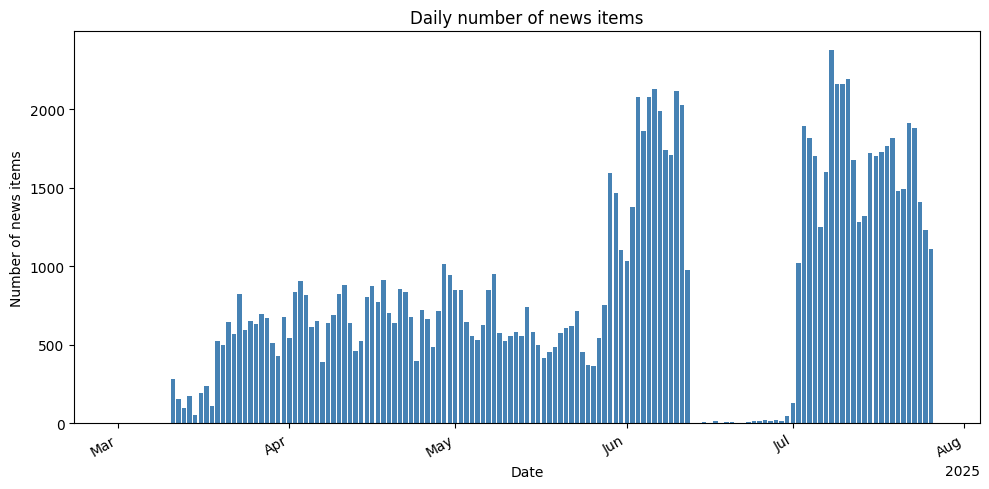

In [ ]:
plot_path = Path("news_article_counts_by_date.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas().sort_values("date")
# print(f"🔄 Loaded daily counts JSON: {len(df_loaded_pd)} records "
#       f"(from {df_loaded_pd['date'].min().date()} to {df_loaded_pd['date'].max().date()})")

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar("date", "news_count", data=df_loaded_pd, color="steelblue")
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_loaded_pd["date"])
plt.tight_layout()
plt.show()


In [ ]:
# 9. Load Language Counts JSON and Plot

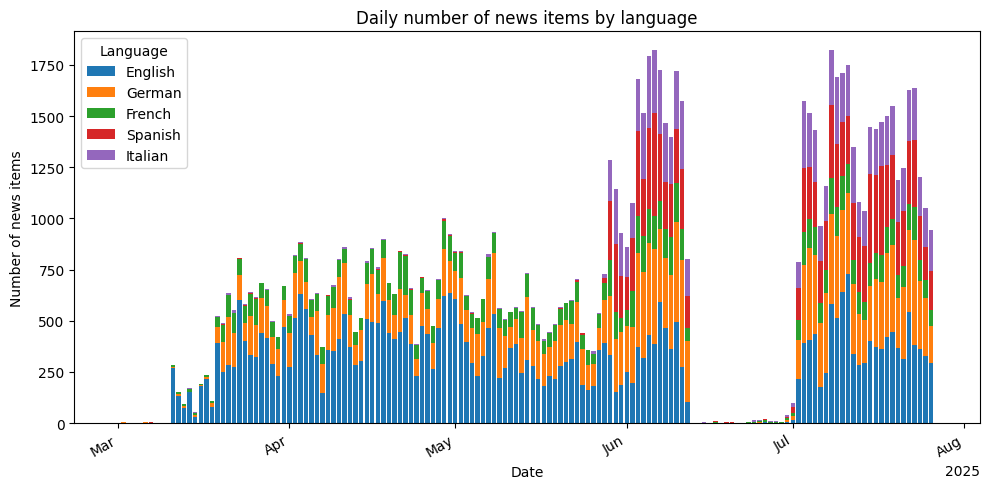

In [ ]:
plot_path = Path("news_article_counts_by_language.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# print(f"🔄 Loaded language counts JSON: shape = {df_loaded_pd.shape} (dates x languages)")

TOP_N = 5
INCLUDE_OTHER = False
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_langs = sums.nlargest(TOP_N).index.tolist()
    other_langs = [col for col in df_loaded_pd.columns if col not in top_langs and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_langs:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_langs].sum(axis=1)
        categories = top_langs + ["Other"]
    else:
        categories = top_langs
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]

# print(f"Plotting {len(categories)} languages: {categories}")

fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Language")
plt.tight_layout()
plt.show()

# Optionally, visualize only a selected language (uncomment to use):
# available_languages = [col for col in df_loaded_pd.columns if col != "date"]
# print("Available languages:", available_languages)
# selected_language = "en"  # example: choose a language from available_languages
# df_single_lang = df_loaded_pd[["date", selected_language]].copy()
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df_single_lang["date"], df_single_lang[selected_language], color="steelblue")
# ax.set_xlabel("Date")
# ax.set_ylabel(plot_d_loaded.get("ylabel"))
# ax.set_title(f"Daily number of news items (Language: {selected_language})")
# _maybe_format_date_axis(ax, df_single_lang["date"])
# plt.tight_layout()
# plt.show()


In [ ]:
# 10. Load Country Counts JSON and Plot

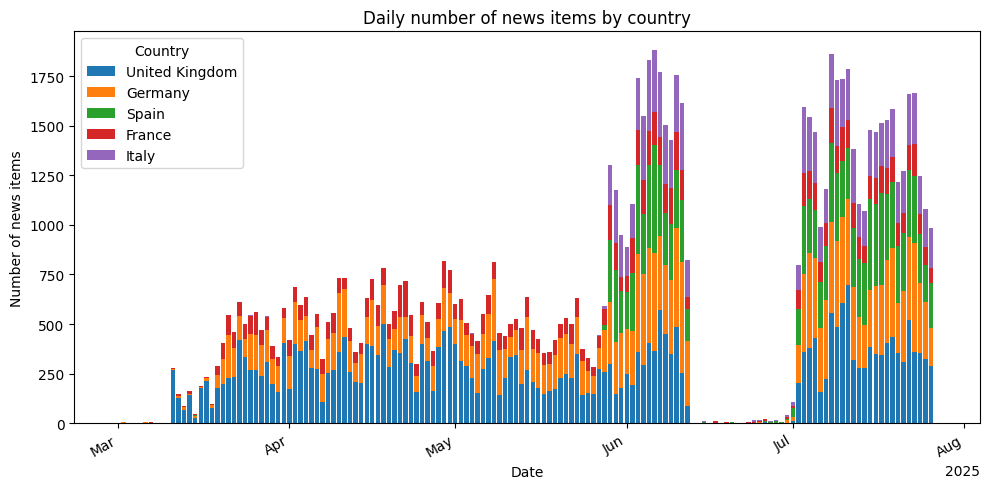

In [ ]:
plot_path = Path("news_article_counts_by_country.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# print(f"🔄 Loaded country counts JSON: shape = {df_loaded_pd.shape} (dates x countries)")

TOP_N = 5
INCLUDE_OTHER = False
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_countries = sums.nlargest(TOP_N).index.tolist()
    other_countries = [col for col in df_loaded_pd.columns if col not in top_countries and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_countries:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_countries].sum(axis=1)
        categories = top_countries + ["Other"]
    else:
        categories = top_countries
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]

# print(f"Plotting {len(categories)} countries: {categories}")

fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Country")
plt.tight_layout()
plt.show()

# Optionally, visualize only a selected country (uncomment to use):
# available_countries = [col for col in df_loaded_pd.columns if col != "date"]
# print("Available countries:", available_countries)
# selected_country = "US"  # example: choose a country from available_countries
# df_single_country = df_loaded_pd[["date", selected_country]].copy()
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df_single_country["date"], df_single_country[selected_country], color="steelblue")
# ax.set_xlabel("Date")
# ax.set_ylabel(plot_d_loaded.get("ylabel"))
# ax.set_title(f"Daily number of news items (Country: {selected_country})")
# _maybe_format_date_axis(ax, df_single_country["date"])
# plt.tight_layout()
# plt.show()


In [ ]:
# 11. Load Topic Counts JSON and Plot

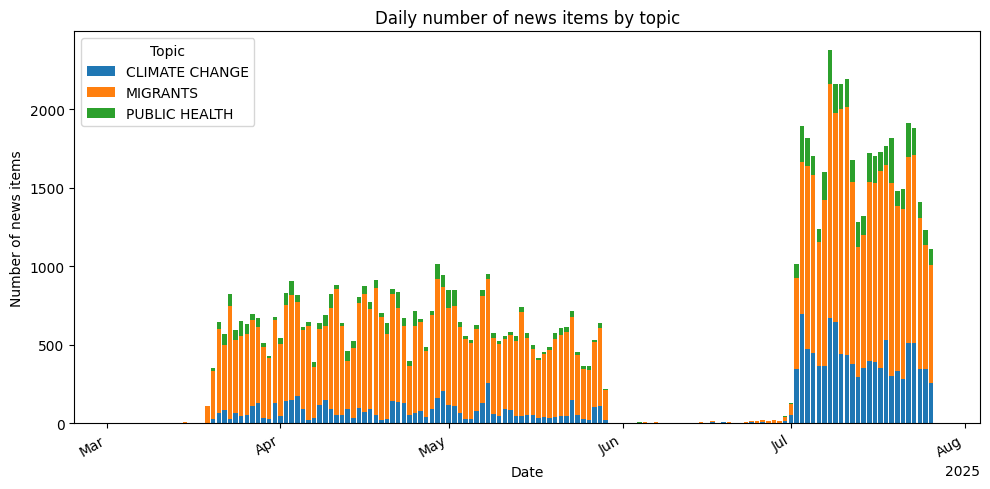

In [ ]:
plot_path = Path("news_article_counts_by_topic.json")
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# print(f"🔄 Loaded topic counts JSON: shape = {df_loaded_pd.shape} (dates x topics)")

TOP_N = 10
INCLUDE_OTHER = True
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_topics = sums.nlargest(TOP_N).index.tolist()
    other_topics = [col for col in df_loaded_pd.columns if col not in top_topics and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_topics:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_topics].sum(axis=1)
        categories = top_topics + ["Other"]
    else:
        categories = top_topics
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]

# print(f"Plotting {len(categories)} topics: {categories}")

fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"))
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Topic")
plt.tight_layout()
plt.show()

# Optionally, visualize only a selected topic/category (uncomment to use):
# available_topics = [col for col in df_loaded_pd.columns if col != "date"]
# print("Available topics:", available_topics)
# selected_topic = "Politics"  # example: choose a topic from available_topics
# df_single_topic = df_loaded_pd[["date", selected_topic]].copy()
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df_single_topic["date"], df_single_topic[selected_topic], color="steelblue")
# ax.set_xlabel("Date")
# ax.set_ylabel(plot_d_loaded.get("ylabel"))
# ax.set_title(f"Daily number of news items (Topic: {selected_topic})")
# _maybe_format_date_axis(ax, df_single_topic["date"])
# plt.tight_layout()
# plt.show()
